lmax is 1575


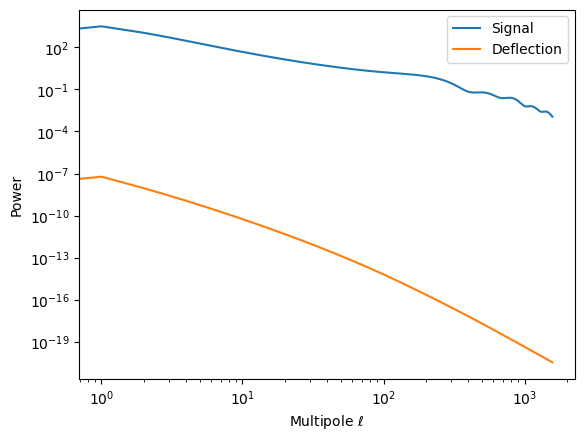

In [5]:
import numpy as np
import cunusht
from cunusht.utils import good_lmax_array, Alm, synalm, alm2cl
import matplotlib.pyplot as plt
import healpy as hp

def camb_clfile(fname, lmax=None):
    """CAMB spectra (lenspotentialCls, lensedCls or tensCls types) returned as a dict of numpy arrays.

    Args:
        fname (str): path to CAMB output file
        lmax (int, optional): outputs cls truncated at this multipole.

    """
    cols = np.loadtxt(fname).transpose()
    ell = np.int_(cols[0])
    if lmax is None: lmax = ell[-1]
    assert ell[-1] >= lmax, (ell[-1], lmax)
    cls = {k : np.zeros(lmax + 1, dtype=float) for k in ['tt', 'ee', 'bb', 'te']}
    w = ell * (ell + 1) / (2. * np.pi)  # weights in output file
    idc = np.where(ell <= lmax) if lmax is not None else np.arange(len(ell), dtype=int)
    for i, k in enumerate(['tt', 'ee', 'bb', 'te']):
        cls[k][ell[idc]] = cols[i + 1][idc] / w[idc]
    if len(cols) > 5:
        wpp = lambda ell : ell ** 2 * (ell + 1) ** 2 / (2. * np.pi)
        wptpe = lambda ell : np.sqrt(ell.astype(float) ** 3 * (ell + 1.) ** 3) / (2. * np.pi)
        for i, k in enumerate(['pp', 'pt', 'pe']):
            cls[k] = np.zeros(lmax + 1, dtype=float)
        cls['pp'][ell[idc]] = cols[5][idc] / wpp(ell[idc])
        cls['pt'][ell[idc]] = cols[6][idc] / wptpe(ell[idc])
        cls['pe'][ell[idc]] = cols[7][idc] / wptpe(ell[idc])
    return cls

lmax = good_lmax_array[20]
cls = camb_clfile("/mnt/home/sbelkner/git/delensalot/delensalot/data/cls/FFP10_wdipole_lenspotentialCls.dat")
print(f"lmax is {lmax}")
clsig, cldef = cls['tt'][:lmax+1], cls['pp'][:lmax+1]
plt.plot(clsig, label='Signal')
plt.plot(cldef, label='Deflection')
plt.loglog()
plt.xlabel(r'Multipole $\ell$')
plt.ylabel("Power")
plt.legend()
plt.show()

In [2]:
toyundeflm = synalm(clsig, lmax=lmax, mmax=lmax)
toydeflm = synalm(cldef, lmax=lmax, mmax=lmax)
kwargs = {
    'geominfo_deflection': ('gl',{'lmax': lmax}),
    'dglm': toydeflm,
    'mmax_dlm': lmax,
    'nthreads': 20,
    'verbose': 0,
    'epsilon': 1e-08,
    'single_prec': False
}

t = cunusht.get_transformer(backend="CPU")(**kwargs)

lenmap = t.gclm2lenmap(toyundeflm.copy(), dlm=toydeflm, lmax=lmax, mmax=lmax, spin=0, nthreads=kwargs["nthreads"])
print(f"This is your lenmap: {lenmap}")

gclm = np.zeros_like(toyundeflm)
gclm = t.lenmap2gclm(np.atleast_2d(lenmap.copy()), dlm=toydeflm, lmax=lmax, mmax=lmax, spin=0, gclm_out=gclm, nthreads=kwargs["nthreads"])
print(f"This is your gclm: {gclm}")

This is your lenmap: [[-65.41212046 -65.53709684 -65.66196415 ... 113.26929621 113.37508136
  113.48044122]]
This is your gclm: [[-7.34247734e+06+5.31343858e-11j -2.99335260e+07+4.69417367e-10j
  -2.28872785e+07+1.03972423e-09j ... -1.38226237e+04-3.38053401e+03j
  -9.97670199e+03-1.26205672e+04j  5.39635749e+03+4.05384407e+03j]]


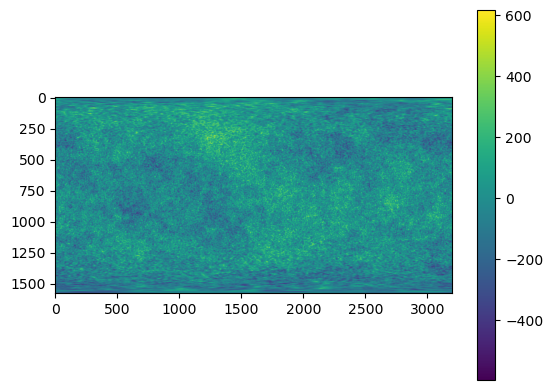

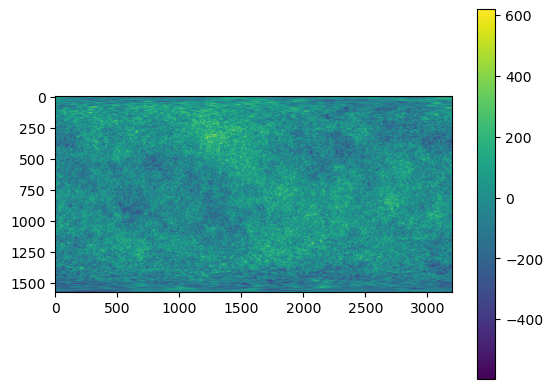

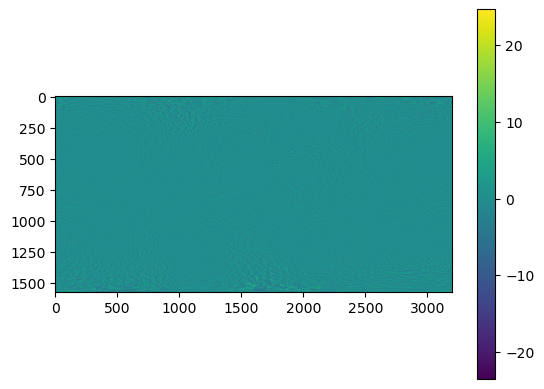

In [60]:
m = np.empty(t.deflectionlib.geom.npix())
plt.imshow(t.synthesis(toyundeflm, out=None, spin=0, lmax=lmax, mmax=lmax, nthreads=10).reshape(lmax+1,-1))
plt.colorbar()
plt.show()
plt.imshow(lenmap.reshape(lmax+1,-1))
plt.colorbar()
plt.show()

plt.imshow(t.synthesis(toyundeflm, out=None, spin=0, lmax=lmax, mmax=lmax, nthreads=10).reshape(lmax+1,-1)-lenmap.reshape(lmax+1,-1))
plt.colorbar()
plt.show()

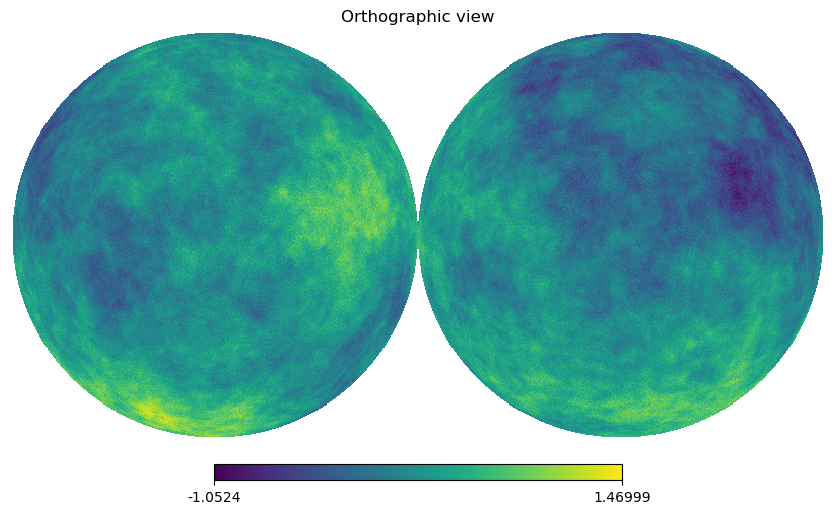

In [78]:
hp.orthview(hp.alm2map(toyundeflm,nside=512))

In [2]:
import numpy as np
import cupy as cp
import cunusht
from cunusht.utils import good_lmax_array, Alm, synalm, almxfl
import matplotlib.pyplot as plt

lmax = good_lmax_array[20]
print(f"lmax is {lmax}")
toyundeflm = synalm(clsig, lmax=lmax, mmax=lmax)
toydeflm = synalm(cldef, lmax=lmax, mmax=lmax)
ll = np.arange(0,lmax+1,1)
toydeflm = almxfl(toydeflm, np.nan_to_num(np.sqrt(1/(ll*(ll+1)))), mmax=lmax, inplace=False)


kwargs = {
    'geominfo_deflection': ('gl',{'lmax': lmax}),
    'epsilon': 1e-08,
    "nuFFTtype": 2,
}
t = cunusht.get_transformer(backend="GPU")(**kwargs)

lenmap = cp.empty(t.deflectionlib.constructor.spat_shape, dtype=cp.complex128).flatten()
lenmap = t.gclm2lenmap(toyundeflm.copy(), dlm_scaled=toydeflm, lmax=lmax, mmax=lmax, lenmap=lenmap)
print(f"This is your lenmap: {lenmap}")

lmax is 1575


/tmp/ipykernel_449654/2760662807.py:12: RuntimeWarning: divide by zero encountered in divide
  toydeflm = almxfl(toydeflm, np.nan_to_num(np.sqrt(1/(ll*(ll+1)))), mmax=lmax, inplace=False)


[SHTns 3.6.6] built Jun 14 2024, 12:05:03, id: v3.6.6-19-ga506ac0*,avx512,ishioka,openmp,cuda
initializing shtns for CC in GPU_SHTns_transformer
geominfo for CC in GPU_SHTns_transformer:  ('cc', {'lmax': 1575, 'mmax': 1575, 'ntheta': 1584, 'nphi': 3168})
[SHTns 3.6.6] built Jun 14 2024, 12:05:03, id: v3.6.6-19-ga506ac0*,avx512,ishioka,openmp,cuda
        Lmax=1575, Mmax*Mres=1575, Mres=1, Nlm=1242676  [10 threads, orthonormalized]
        > Condon-Shortley phase = 1, normalization = 0
!WARNING! Nlat must be larger than 2*Lmax for analysis to work (sampling theorem)!        => using FFTW : Mmax=1575, Nphi=3168, Nlat=1584, Nbatch=1       !! Warning : Nphi is not optimal for FFTW !
(theta-contiguous layout: phi_inc=1584, theta_inc=1)
     !! Warning : Nphi is not optimal for FFTW !
          fftw cost ifftc=5.15414e+07,  fftc=5.15414e+07
          Memory used for Ylm and Zlm matrices = 22526.536 Mb x2
        => using Regular nodes including poles, with Clenshaw-Curtis quadrature
     !! 

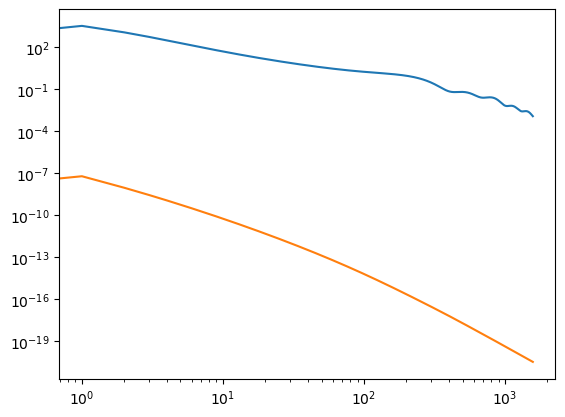

In [5]:
plt.plot(clsig)
plt.plot(cldef)
plt.loglog()
plt.show()

In [ ]:
import numpy as np
import cupy as cp
import cunusht
from cunusht.utils import good_lmax_array, Alm, synalm, almxfl
import matplotlib.pyplot as plt

lmax = good_lmax_array[20]
print(f"lmax is {lmax}")

toyundeflm = synalm(clsig, lmax=lmax, mmax=lmax)
toydeflm = synalm(cldef, lmax=lmax, mmax=lmax)
kwargs = {
    'geominfo_deflection': ('gl',{'lmax': lmax}),
    'dglm': toydeflm,
    'mmax_dlm': lmax,
    'nthreads': 20,
    'verbose': 0,
    'epsilon': 1e-08,
    'single_prec': False
}

t = cunusht.get_transformer(backend="CPU")(**kwargs)

lenmap = t.gclm2lenmap(toyundeflm.copy(), dlm=toydeflm, lmax=lmax, mmax=lmax, spin=0, nthreads=kwargs["nthreads"])
lmax = good_lmax_array[15]
print(f"lmax is {lmax}")
cldef = np.cos(1e-3*np.arange(0,lmax+1))**2*1e-6
toydeflm = synalm(cldef, lmax=lmax, mmax=lmax)
ll = np.arange(0,lmax+1,1)
toydeflm = almxfl(toydeflm, np.nan_to_num(np.sqrt(1/(ll*(ll+1)))), mmax=lmax, inplace=False)

kwargs = {
    'geominfo_deflection': ('gl',{'lmax': lmax}),
    'epsilon': 1e-08,
    "nuFFTtype": 1,
}
t = cunusht.get_transformer(backend="GPU")(**kwargs)

gclm = np.zeros_like(toyundeflm, dtype=cp.complex128)
gclm = t.lenmap2gclm(np.atleast_2d(lenmap.copy().astype(np.complex128)), dlm_scaled=np.atleast_2d(toydeflm), lmax=lmax, mmax=lmax, gclm=gclm)
print(f"This is your gclm: {gclm}")